Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                image label
0  Img/img001-001.png     0
1  Img/img001-002.png     0
2  Img/img001-003.png     0
3  Img/img001-004.png     0
4  Img/img001-005.png     0
Loading images...
Training set: (2182, 1024), (2182,)
Validation set: (546, 1024), (546,)
Test set: (682, 1024), (682,)
Training PLA...
Epoch 10/100, Error Rate: 0.3639
Epoch 20/100, Error Rate: 0.2273
Epoch 30/100, Error Rate: 0.1320
Epoch 40/100, Error Rate: 0.0930
Epoch 50/100, Error Rate: 0.0687
Epoch 60/100, Error Rate: 0.0733
Epoch 70/100, Error Rate: 0.0371
Epoch 80/100, Error Rate: 0.0367
Epoch 90/100, Error Rate: 0.0316
Epoch 100/100, Error Rate: 0.0234


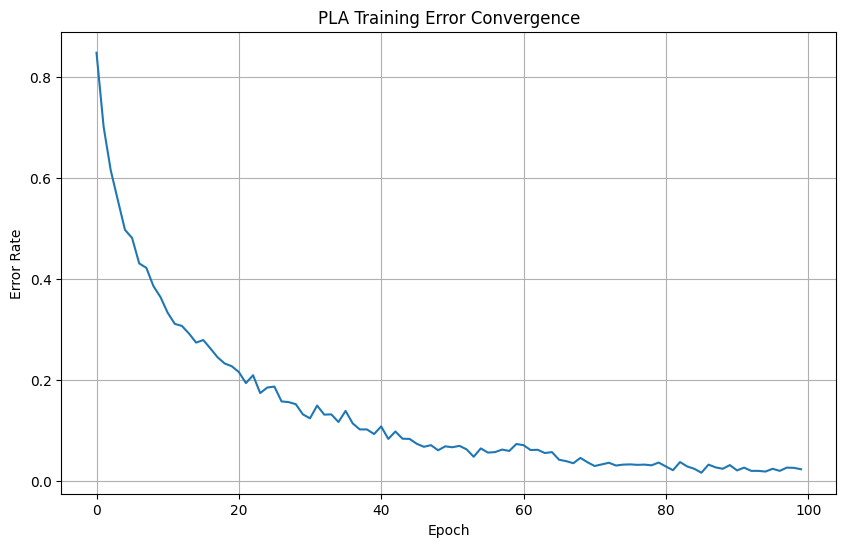

PLA Test Accuracy: 0.2419
PLA Test Precision: 0.2491
PLA Test Recall: 0.2419
PLA Test F1-Score: 0.2410


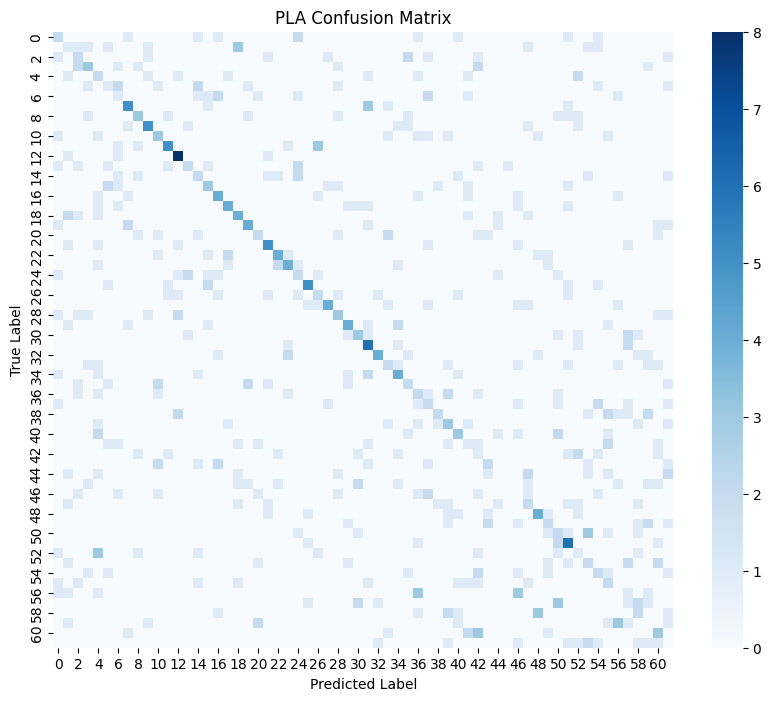


Classification Report for PLA:
              precision    recall  f1-score   support

           0       0.15      0.18      0.17        11
           1       0.08      0.09      0.09        11
           2       0.17      0.18      0.17        11
           3       0.30      0.27      0.29        11
           4       0.11      0.18      0.13        11
           5       0.11      0.09      0.10        11
           6       0.09      0.09      0.09        11
           7       0.42      0.45      0.43        11
           8       0.33      0.27      0.30        11
           9       0.50      0.45      0.48        11
           A       0.25      0.27      0.26        11
           B       0.50      0.45      0.48        11
           C       0.50      0.73      0.59        11
           D       0.33      0.18      0.24        11
           E       0.18      0.18      0.18        11
           F       0.27      0.27      0.27        11
           G       0.31      0.36      0.33      

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive (if running in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset information
data_path = '/content/drive/MyDrive/ml5/'  # Update this path
csv_file = pd.read_csv(data_path + 'english.csv')  # Update with your CSV filename

# Display first few rows
print(csv_file.head())

# Function to load and preprocess images
def load_images(image_paths, img_size=(32, 32)):
    images = []
    for img_path in image_paths:
        # Construct full path
        full_path = data_path + img_path

        # Open and resize image
        img = Image.open(full_path).convert('L')  # Convert to grayscale
        img = img.resize(img_size)

        # Convert to numpy array and normalize
        img_array = np.array(img) / 255.0

        # Flatten the image
        img_flattened = img_array.flatten()

        images.append(img_flattened)

    return np.array(images)

# Load and preprocess images
print("Loading images...")
X = load_images(csv_file['image'])
y = csv_file['label'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors for MLP
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


# Perceptron Learning Algorithm (PLA) Implementation
class PLA:
    def __init__(self, input_size, num_classes, learning_rate=0.01):
        self.weights = np.zeros((num_classes, input_size))
        self.bias = np.zeros(num_classes)
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.train_errors = []  # To track training errors per epoch

    def step_activation(self, x):
        return np.where(x >= 0, 1, 0)

    def predict(self, x):
        # One-vs-all approach for multiclass
        outputs = np.dot(self.weights, x) + self.bias
        return np.argmax(outputs)

    def predict_proba(self, x):
        # For ROC curve, we need probability estimates
        outputs = np.dot(self.weights, x) + self.bias
        # Simple softmax-like conversion (not exactly probabilities but works for ROC)
        exp_outputs = np.exp(outputs - np.max(outputs))  # For numerical stability
        return exp_outputs / np.sum(exp_outputs)

    def train(self, X, y, epochs=100):
        n_samples = X.shape[0]

        for epoch in range(epochs):
            errors = 0
            for i in range(n_samples):
                x_i = X[i]
                y_true = y[i]

                # Prediction
                y_pred = self.predict(x_i)

                # Update weights if prediction is wrong
                if y_pred != y_true:
                    # Decrease score for wrong class
                    self.weights[y_pred] -= self.learning_rate * x_i
                    self.bias[y_pred] -= self.learning_rate

                    # Increase score for correct class
                    self.weights[y_true] += self.learning_rate * x_i
                    self.bias[y_true] += self.learning_rate

                    errors += 1

            # Record error rate for this epoch
            error_rate = errors / n_samples
            self.train_errors.append(error_rate)

            # Print progress
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Error Rate: {error_rate:.4f}")

            # Early stopping if no errors
            if errors == 0:
                print(f"Converged at epoch {epoch+1}")
                break

    def evaluate(self, X, y):
        n_samples = X.shape[0]
        y_pred = []
        y_proba = []

        for i in range(n_samples):
            pred = self.predict(X[i])
            y_pred.append(pred)
            y_proba.append(self.predict_proba(X[i]))

        return np.array(y_pred), np.array(y_proba)

# Initialize and train PLA
print("Training PLA...")
input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))

pla = PLA(input_size, num_classes, learning_rate=0.01)
pla.train(X_train, y_train, epochs=100)

# Plot PLA training convergence
plt.figure(figsize=(10, 6))
plt.plot(pla.train_errors)
plt.title('PLA Training Error Convergence')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

# Evaluate PLA
y_pred_pla, y_proba_pla = pla.evaluate(X_test, y_test)
pla_accuracy = accuracy_score(y_test, y_pred_pla)
pla_precision = precision_score(y_test, y_pred_pla, average='weighted', zero_division=0)
pla_recall = recall_score(y_test, y_pred_pla, average='weighted', zero_division=0)
pla_f1 = f1_score(y_test, y_pred_pla, average='weighted', zero_division=0)

print(f"PLA Test Accuracy: {pla_accuracy:.4f}")
print(f"PLA Test Precision: {pla_precision:.4f}")
print(f"PLA Test Recall: {pla_recall:.4f}")
print(f"PLA Test F1-Score: {pla_f1:.4f}")

# Confusion matrix for PLA
plt.figure(figsize=(10, 8))
cm_pla = confusion_matrix(y_test, y_pred_pla)
sns.heatmap(cm_pla, annot=False, fmt='d', cmap='Blues')
plt.title('PLA Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report for PLA
class_names = label_encoder.classes_
print("\nClassification Report for PLA:")
print(classification_report(y_test, y_pred_pla, target_names=class_names, zero_division=0))







Starting hyperparameter tuning...
Testing: Layers=[128], Activation=relu, LR=0.001, Optimizer=adam
Epoch 10/50, Train Loss: 1.3300, Val Loss: 2.5775
Train Acc: 0.6522, Val Acc: 0.4103
Epoch 20/50, Train Loss: 0.7700, Val Loss: 2.7177
Train Acc: 0.7961, Val Acc: 0.4432
Early stopping at epoch 27
Validation Accuracy: 0.4286
New best model found!
Testing: Layers=[128], Activation=relu, LR=0.001, Optimizer=sgd
Epoch 10/50, Train Loss: 3.8321, Val Loss: 4.0181
Train Acc: 0.1687, Val Acc: 0.1410
Epoch 20/50, Train Loss: 3.4419, Val Loss: 3.7410
Train Acc: 0.2786, Val Acc: 0.2289
Epoch 30/50, Train Loss: 2.9941, Val Loss: 3.4268
Train Acc: 0.3520, Val Acc: 0.2729
Epoch 40/50, Train Loss: 2.5926, Val Loss: 3.1459
Train Acc: 0.4317, Val Acc: 0.3168
Epoch 50/50, Train Loss: 2.2825, Val Loss: 2.9391
Train Acc: 0.4863, Val Acc: 0.3370
Validation Accuracy: 0.3370
Testing: Layers=[128], Activation=relu, LR=0.01, Optimizer=adam
Epoch 10/50, Train Loss: 1.6193, Val Loss: 13.8600
Train Acc: 0.6577, Val

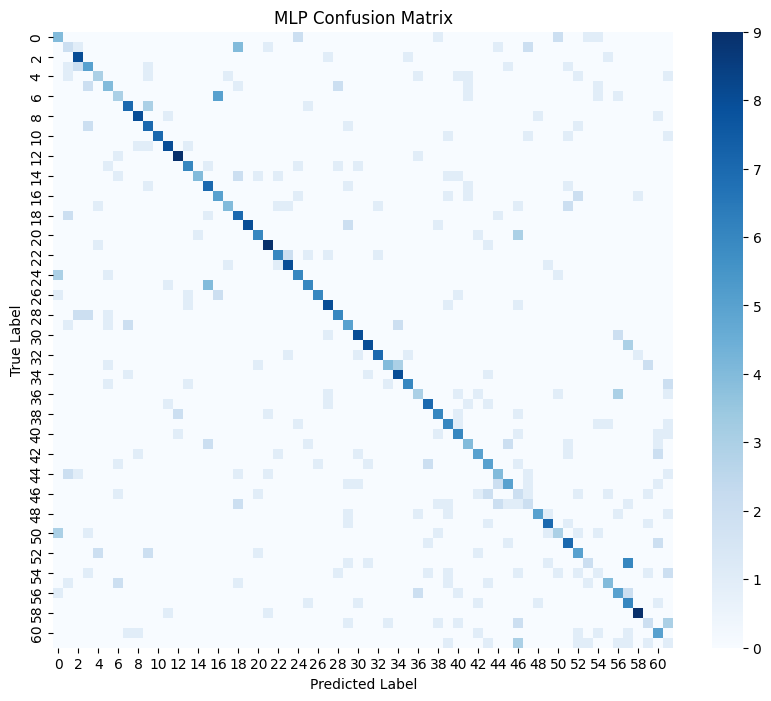

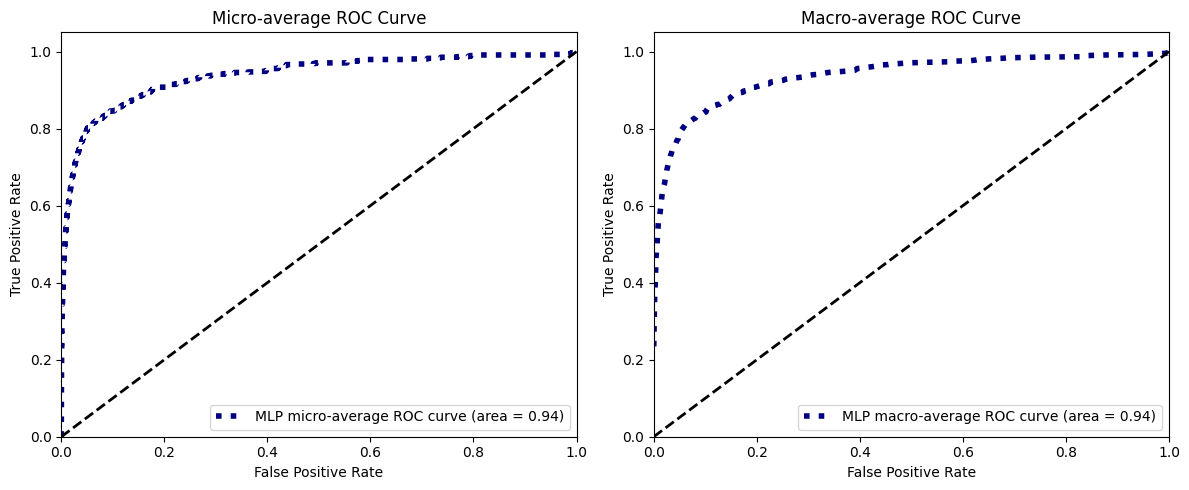


Classification Report for MLP:
              precision    recall  f1-score   support

           0       0.33      0.36      0.35        11
           1       0.20      0.18      0.19        11
           2       0.57      0.73      0.64        11
           3       0.38      0.45      0.42        11
           4       0.43      0.27      0.33        11
           5       0.40      0.36      0.38        11
           6       0.33      0.27      0.30        11
           7       0.64      0.64      0.64        11
           8       0.73      0.73      0.73        11
           9       0.44      0.64      0.52        11
           A       1.00      0.64      0.78        11
           B       0.67      0.73      0.70        11
           C       0.75      0.82      0.78        11
           D       0.60      0.55      0.57        11
           E       0.80      0.36      0.50        11
           F       0.47      0.64      0.54        11
           G       0.42      0.45      0.43      

NameError: name 'visualize_mlp_predictions' is not defined

In [4]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', dropout_rate=0.2):
        super(MLP, self).__init__()

        # Create layers
        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))

            # Add activation function
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'tanh':
                layers.append(nn.Tanh())

            # Add dropout for regularization
            layers.append(nn.Dropout(dropout_rate))

            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Training function with detailed metrics tracking
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0.0
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = train_correct / train_total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Check for improvement
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
            print(f"Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Evaluation function with probability outputs
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    return accuracy, np.array(all_preds), np.array(all_labels), np.array(all_probs)

# --- IMPORTANT: ensure DataLoaders exist (this is the minimal required fix) ---
# You already created train_dataset, val_dataset, test_dataset earlier.
# Create matching DataLoader objects expected by the training/eval code:

batch_size = 64  # adjust if you want
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Hyperparameter tuning
hidden_layers_options = [[128], [256], [128, 64], [256, 128]]
activation_options = ['relu', 'sigmoid', 'tanh']
learning_rates = [0.001, 0.01, 0.1]
optimizers_list = ['adam', 'sgd']

# Tuning loop
best_val_acc = 0
best_params = {}
best_model = None
all_results = []

print("Starting hyperparameter tuning...")

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))

for hidden_layers in hidden_layers_options:
    for activation in activation_options:
        for lr in learning_rates:
            for opt_name in optimizers_list:
                print(f"Testing: Layers={hidden_layers}, Activation={activation}, LR={lr}, Optimizer={opt_name}")

                # Initialize model
                model = MLP(input_size, hidden_layers, num_classes, activation=activation)

                # Define loss and optimizer
                criterion = nn.CrossEntropyLoss()

                if opt_name == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                else:
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

                # Train model
                model, train_losses, val_losses, train_accs, val_accs = train_model(
                    model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=50, patience=7
                )

                # Evaluate on validation set
                val_acc, _, _, _ = evaluate_model(model, val_loader)

                print(f"Validation Accuracy: {val_acc:.4f}")

                # Store results
                result = {
                    'hidden_layers': hidden_layers,
                    'activation': activation,
                    'learning_rate': lr,
                    'optimizer': opt_name,
                    'val_accuracy': val_acc,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_accs': train_accs,
                    'val_accs': val_accs
                }
                all_results.append(result)

                # Update best model
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_params = {
                        'hidden_layers': hidden_layers,
                        'activation': activation,
                        'learning_rate': lr,
                        'optimizer': opt_name
                    }
                    best_model = model
                    print("New best model found!")

print("Tuning completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Best parameters: {best_params}")


# Train the best model with more epochs
print("Training best model with optimal parameters...")

# Reinitialize best model with best parameters
final_model = MLP(
    input_size,
    best_params['hidden_layers'],
    num_classes,
    activation=best_params['activation']
)

criterion = nn.CrossEntropyLoss()

if best_params['optimizer'] == 'adam':
    optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
else:
    optimizer = optim.SGD(final_model.parameters(), lr=best_params['learning_rate'], momentum=0.9)

# Train the model
final_model, train_losses, val_losses, train_accs, val_accs = train_model(
    final_model, train_loader, val_loader, criterion, optimizer,
    num_epochs=100, patience=10
)


# Evaluate on test set
mlp_test_acc, mlp_preds, mlp_true, mlp_probs = evaluate_model(final_model, test_loader)
mlp_precision = precision_score(mlp_true, mlp_preds, average='weighted', zero_division=0)
mlp_recall = recall_score(mlp_true, mlp_preds, average='weighted', zero_division=0)
mlp_f1 = f1_score(mlp_true, mlp_preds, average='weighted', zero_division=0)

print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")
print(f"MLP Test Precision: {mlp_precision:.4f}")
print(f"MLP Test Recall: {mlp_recall:.4f}")
print(f"MLP Test F1-Score: {mlp_f1:.4f}")

# Confusion matrix for MLP
plt.figure(figsize=(10, 8))
cm_mlp = confusion_matrix(mlp_true, mlp_preds)
sns.heatmap(cm_mlp, annot=False, fmt='d', cmap='Blues')
plt.title('MLP Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curves
# Binarize the output for ROC curve
y_test_bin_mlp = label_binarize(mlp_true, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class for MLP
fpr_mlp = dict()
tpr_mlp = dict()
roc_auc_mlp = dict()

for i in range(num_classes):
    fpr_mlp[i], tpr_mlp[i], _ = roc_curve(y_test_bin_mlp[:, i], mlp_probs[:, i])
    roc_auc_mlp[i] = auc(fpr_mlp[i], tpr_mlp[i])

# Compute micro-average ROC curve and ROC area for MLP
fpr_mlp["micro"], tpr_mlp["micro"], _ = roc_curve(y_test_bin_mlp.ravel(), mlp_probs.ravel())
roc_auc_mlp["micro"] = auc(fpr_mlp["micro"], tpr_mlp["micro"])

# Plot ROC curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_mlp["micro"], tpr_mlp["micro"],
         label='MLP micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_mlp["micro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")

# Macro-average ROC curve
all_fpr_mlp = np.unique(np.concatenate([fpr_mlp[i] for i in range(num_classes)]))

mean_tpr_mlp = np.zeros_like(all_fpr_mlp)
for i in range(num_classes):
    mean_tpr_mlp += np.interp(all_fpr_mlp, fpr_mlp[i], tpr_mlp[i])
mean_tpr_mlp /= num_classes

fpr_mlp["macro"] = all_fpr_mlp
tpr_mlp["macro"] = mean_tpr_mlp
roc_auc_mlp["macro"] = auc(fpr_mlp["macro"], tpr_mlp["macro"])

plt.subplot(1, 2, 2)
plt.plot(fpr_mlp["macro"], tpr_mlp["macro"],
         label='MLP macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_mlp["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Classification report for MLP
class_names = label_encoder.classes_
print("\nClassification Report for MLP:")
print(classification_report(mlp_true, mlp_preds, target_names=class_names, zero_division=0))


# Define hyperparameters to tune
hidden_layers_options = [[128], [256], [128, 64], [256, 128]]
activation_options = ['relu', 'sigmoid', 'tanh']
learning_rates = [0.001, 0.01, 0.1]
optimizers_list = ['adam', 'sgd']

# Tuning loop
best_val_acc = 0
best_params = {}
best_model = None
all_results = []

print("Starting hyperparameter tuning...")

for hidden_layers in hidden_layers_options:
    for activation in activation_options:
        for lr in learning_rates:
            for opt_name in optimizers_list:
                print(f"Testing: Layers={hidden_layers}, Activation={activation}, LR={lr}, Optimizer={opt_name}")

                # Initialize model
                model = MLP(input_size, hidden_layers, num_classes, activation=activation)

                # Define loss and optimizer
                criterion = nn.CrossEntropyLoss()

                if opt_name == 'adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                else:
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

                # Train model
                model, train_losses, val_losses, train_accs, val_accs = train_model(
                    model, train_loader, val_loader, criterion, optimizer,
                    num_epochs=50, patience=7
                )

                # Evaluate on validation set
                val_acc, _, _, _ = evaluate_model(model, val_loader)

                print(f"Validation Accuracy: {val_acc:.4f}")

                # Store results
                result = {
                    'hidden_layers': hidden_layers,
                    'activation': activation,
                    'learning_rate': lr,
                    'optimizer': opt_name,
                    'val_accuracy': val_acc,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_accs': train_accs,
                    'val_accs': val_accs
                }
                all_results.append(result)

                # Update best model
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_params = {
                        'hidden_layers': hidden_layers,
                        'activation': activation,
                        'learning_rate': lr,
                        'optimizer': opt_name
                    }
                    best_model = model
                    print("New best model found!")

print("Tuning completed!")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Best parameters: {best_params}")

# Plot training curves for all configurations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, result in enumerate(all_results):
    axes[0].plot(result['train_losses'], label=f"Config {i+1}")
    axes[1].plot(result['val_losses'], label=f"Config {i+1}")
    axes[2].plot(result['train_accs'], label=f"Config {i+1}")
    axes[3].plot(result['val_accs'], label=f"Config {i+1}")

axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].set_title('Training Accuracy')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].legend()

axes[3].set_title('Validation Accuracy')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Accuracy')
axes[3].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Train the best model with more epochs if needed
print("Training best model with optimal parameters...")

# Reinitialize best model with best parameters
final_model = MLP(
    input_size,
    best_params['hidden_layers'],
    num_classes,
    activation=best_params['activation']
)

criterion = nn.CrossEntropyLoss()

if best_params['optimizer'] == 'adam':
    optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
else:
    optimizer = optim.SGD(final_model.parameters(), lr=best_params['learning_rate'], momentum=0.9)

# Train the model
final_model, train_losses, val_losses, train_accs, val_accs = train_model(
    final_model, train_loader, val_loader, criterion, optimizer,
    num_epochs=100, patience=10
)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot learning curve (accuracy vs loss)
plt.subplot(1, 3, 3)
plt.plot(train_losses, train_accs, 'o-', label='Training')
plt.plot(val_losses, val_accs, 'o-', label='Validation')
plt.title('Learning Curve')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
mlp_test_acc, mlp_preds, mlp_true, mlp_probs = evaluate_model(final_model, test_loader)
mlp_precision = precision_score(mlp_true, mlp_preds, average='weighted', zero_division=0)
mlp_recall = recall_score(mlp_true, mlp_preds, average='weighted', zero_division=0)
mlp_f1 = f1_score(mlp_true, mlp_preds, average='weighted', zero_division=0)

print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")
print(f"MLP Test Precision: {mlp_precision:.4f}")
print(f"MLP Test Recall: {mlp_recall:.4f}")
print(f"MLP Test F1-Score: {mlp_f1:.4f}")

# Compare with PLA
print("\n=== Model Comparison ===")
print(f"PLA Test Accuracy: {pla_accuracy:.4f}")
print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")
print(f"Improvement: {(mlp_test_acc - pla_accuracy) * 100:.2f}%")

# Confusion matrix for both models
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PLA confusion matrix
cm_pla = confusion_matrix(y_test, y_pred_pla)
sns.heatmap(cm_pla, annot=False, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('PLA Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# MLP confusion matrix
cm_mlp = confusion_matrix(mlp_true, mlp_preds)
sns.heatmap(cm_mlp, annot=False, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('MLP Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# ROC Curves
# Binarize the output for ROC curve
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
y_test_bin_mlp = label_binarize(mlp_true, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class for PLA
fpr_pla = dict()
tpr_pla = dict()
roc_auc_pla = dict()

for i in range(num_classes):
    fpr_pla[i], tpr_pla[i], _ = roc_curve(y_test_bin[:, i], y_proba_pla[:, i])
    roc_auc_pla[i] = auc(fpr_pla[i], tpr_pla[i])

# Compute micro-average ROC curve and ROC area for PLA
fpr_pla["micro"], tpr_pla["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba_pla.ravel())
roc_auc_pla["micro"] = auc(fpr_pla["micro"], tpr_pla["micro"])

# Compute ROC curve and ROC area for each class for MLP
fpr_mlp = dict()
tpr_mlp = dict()
roc_auc_mlp = dict()

for i in range(num_classes):
    fpr_mlp[i], tpr_mlp[i], _ = roc_curve(y_test_bin_mlp[:, i], mlp_probs[:, i])
    roc_auc_mlp[i] = auc(fpr_mlp[i], tpr_mlp[i])

# Compute micro-average ROC curve and ROC area for MLP
fpr_mlp["micro"], tpr_mlp["micro"], _ = roc_curve(y_test_bin_mlp.ravel(), mlp_probs.ravel())
roc_auc_mlp["micro"] = auc(fpr_mlp["micro"], tpr_mlp["micro"])

# Plot ROC curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_pla["micro"], tpr_pla["micro"],
         label='PLA micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_pla["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_mlp["micro"], tpr_mlp["micro"],
         label='MLP micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_mlp["micro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")

# Macro-average ROC curve
# First aggregate all false positive rates
all_fpr_pla = np.unique(np.concatenate([fpr_pla[i] for i in range(num_classes)]))
all_fpr_mlp = np.unique(np.concatenate([fpr_mlp[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr_pla = np.zeros_like(all_fpr_pla)
for i in range(num_classes):
    mean_tpr_pla += np.interp(all_fpr_pla, fpr_pla[i], tpr_pla[i])
mean_tpr_pla /= num_classes

mean_tpr_mlp = np.zeros_like(all_fpr_mlp)
for i in range(num_classes):
    mean_tpr_mlp += np.interp(all_fpr_mlp, fpr_mlp[i], tpr_mlp[i])
mean_tpr_mlp /= num_classes

# Finally compute macro AUC
fpr_pla["macro"] = all_fpr_pla
tpr_pla["macro"] = mean_tpr_pla
roc_auc_pla["macro"] = auc(fpr_pla["macro"], tpr_pla["macro"])

fpr_mlp["macro"] = all_fpr_mlp
tpr_mlp["macro"] = mean_tpr_mlp
roc_auc_mlp["macro"] = auc(fpr_mlp["macro"], tpr_mlp["macro"])

plt.subplot(1, 2, 2)
plt.plot(fpr_pla["macro"], tpr_pla["macro"],
         label='PLA macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_pla["macro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr_mlp["macro"], tpr_mlp["macro"],
         label='MLP macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_mlp["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Classification report for both models
class_names = label_encoder.classes_
print("\nClassification Report for PLA:")
print(classification_report(y_test, y_pred_pla, target_names=class_names, zero_division=0))

print("\nClassification Report for MLP:")
print(classification_report(mlp_true, mlp_preds, target_names=class_names, zero_division=0))



Training best model with optimal parameters...
Epoch 10/100, Train Loss: 2.1754, Val Loss: 2.6481
Train Acc: 0.4239, Val Acc: 0.3535
Epoch 20/100, Train Loss: 1.1252, Val Loss: 2.4386
Train Acc: 0.6751, Val Acc: 0.4542
Epoch 30/100, Train Loss: 0.7396, Val Loss: 2.6306
Train Acc: 0.7750, Val Acc: 0.4725
Epoch 40/100, Train Loss: 0.4438, Val Loss: 2.9511
Train Acc: 0.8721, Val Acc: 0.5018
